In [1]:
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree

# set up env
bd = '.'
wd = join(bd, "..", "data")

In [4]:
# setup cell
# settings
storm = "irma"
region = "tampanorth"
nsubregions = 3
subregion = 0

import math
import xarray as xr
from os.path import join, exists
from os import remove
import warnings
import time

# standard scientific
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
# ! pip install zarr

# gee
import ee

# raster stuff
import dask.distributed
# import pystac_client
import rioxarray  # noqa: F401

# import contextily
import rasterio
import shapely.geometry
from shapely.geometry import Point
from sklearn.neighbors import BallTree
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from ast import literal_eval
from os.path import join
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, shape

from importlib import reload
import viz_utils
import data_utils
from event import Event, pwater_thresh

import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    
    Nearest neighbour analysis: https://autogis-site.readthedocs.io/en/2019/notebooks/L3/nearest-neighbor-faster.html
    
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

plt.rcParams['font.family'] = 'Arial'

# set up env
bd = '.'
wd = join(bd, "..", "data")

# load event GeoDataFrame (as when getting data)
event = Event(storm, region, nsubregions, wd, bd)
event.make_grids()
self = event
event.get_all_features(subregion)

Error for soiltemp1 for irma, tampanorth, 0:'tuple' object has no attribute 'subtract'
Creating empty field.
Error for soiltemp2 for irma, tampanorth, 0:'tuple' object has no attribute 'subtract'
Creating empty field.


In [5]:
def process_xr(ds, starttime, endtime, poly):
    ds = ds.sel(time=slice(starttime, endtime))
    ds_subset = ds.where(
        (ds.station_x_coordinate >= poly.total_bounds[0] - 1) &
        (ds.station_x_coordinate <= poly.total_bounds[2] + 1) & 
        (ds.station_y_coordinate >= poly.total_bounds[1] - 1) &
        (ds.station_y_coordinate <= poly.total_bounds[3] + 1),
        drop = True

    )
    
    surge_data = ds_subset.surge.to_dataframe().reset_index()
    geometry = [Point(xy) for xy in zip(surge_data['station_x_coordinate'], surge_data['station_y_coordinate'])]
    surge_gdf = gpd.GeoDataFrame(surge_data, geometry=geometry, crs=4326)


    station_geoms = surge_gdf.drop_duplicates(subset=['stations'])[['stations', 'geometry']].set_index('stations')

    surge_gdf = surge_gdf[['stations', 'surge', 'geometry']]
    max_surge = surge_gdf.groupby(['stations']).max()
    max_surge = max_surge.set_geometry(station_geoms.geometry)
    
    return max_surge


def load_xr(timerange, extent):
    start = timerange[0]
    end = timerange[1]
    
    if start.month == end.month:
        year = end.year
        month = end.month
        ds = xr.open_dataset(join(wd, 'surge_reanalysis', f'reanalysis_surge_dailymax_{year}_{month:02d}_v1.nc'))
        max_surge = process_xr(ds, start, end, extent)
    else:
        year0, year1 = start.year, end.year
        month0, month1 = start.month, end.month

        ds0 = xr.open_dataset(join(wd, 'surge_reanalysis', f'reanalysis_surge_dailymax_{year0}_{month0:02d}_v1.nc'))
        ds1 = xr.open_dataset(join(wd, 'surge_reanalysis', f'reanalysis_surge_dailymax_{year1}_{month1:02d}_v1.nc'))

        max_surge0 = process_xr(ds0, start, end, extent)
        max_surge1 = process_xr(ds1, start, end, extent)

        max_surge = pd.concat([max_surge0, max_surge1]).drop_duplicates().reset_index()
    return max_surge



def get_gssr(self, subregion, recalculate=False):
    
    acquisition_time = pd.to_datetime(self.acquisition_time)
    start_time = acquisition_time + pd.DateOffset(days=-5)
    aoi_lonlat = self.aoi_lonlat[subregion]
    feature_gdf = self.feature_gdf[subregion]
    
    max_surge = load_xr((start_time, acquisition_time), aoi_lonlat)
    tile_centroid = event.grid_lonlat[subregion].set_geometry(event.grid_lonlat[subregion].centroid)
    closest_stations = nearest_neighbor(tile_centroid,
                                    max_surge,
                                    return_dist=True)
    feature_gdf['gssr'] = closest_stations['surge']
    return feature_gdf

In [6]:
feature_gdf = get_gssr(event, subregion)

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_4826/4288303001.py:58: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tile_centroid = event.grid_lonlat[subregion].set_geometry(event.grid_lonlat[subregion].centroid)


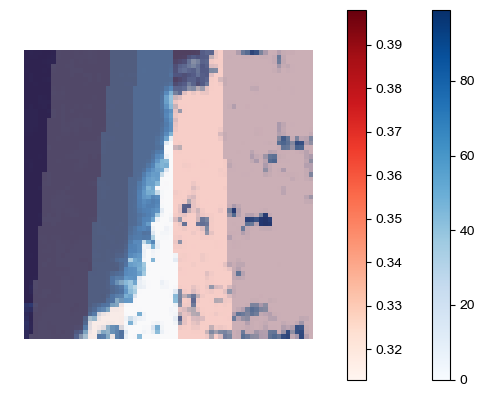

In [11]:
fig, ax = plt.subplots()
# max_surge.plot('surge', cmap='Reds', ax=ax)
feature_gdf.plot('jrc_permwa', legend=True, cmap='Blues', ax=ax)
feature_gdf.plot('gssr', legend=True, ax=ax, cmap='Reds', alpha=0.3)
ax.set_axis_off()

In [63]:
# load tile and GSSR data

tile = gpd.read_file('/Users/alison/Documents/DPhil/hybridmodels/data/feature_stats_spatial/roanu_barguna_1.gpkg')
data = xr.open_dataset('/Users/alison/Documents/DPhil/hybridmodels/data/surge_reanalysis/reanalysis_surge_dailymax_2016_05_v1.nc')
surge_data = data.surge.to_dataframe().reset_index()

In [64]:
geometry = [Point(xy) for xy in zip(surge_data['station_x_coordinate'], surge_data['station_y_coordinate'])]
surge_gdf = gpd.GeoDataFrame(surge_data, geometry=geometry, crs=4326)

In [65]:
surge_storm = surge_gdf[(surge_gdf['time'] >= start_time) & (surge_gdf['time'] <= acquisition_time)]

In [66]:
station_geoms = surge_storm.drop_duplicates(subset=['stations'])[['stations', 'geometry']].set_index('stations')

In [67]:
surge_storm = surge_storm[['stations', 'surge', 'geometry']]
max_surge = surge_storm.groupby(['stations']).max()
max_surge = max_surge.set_geometry(station_geoms.geometry)

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_3732/1571036493.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max_surge = surge_storm.groupby(['stations']).max()


In [68]:
tile_centroid = tile.copy()
tile_centroid = tile_centroid.set_geometry(tile.centroid)

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_3732/3526319627.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tile_centroid = tile_centroid.set_geometry(tile.centroid)


In [70]:
closest_stations = nearest_neighbor(tile_centroid, max_surge, return_dist=True)

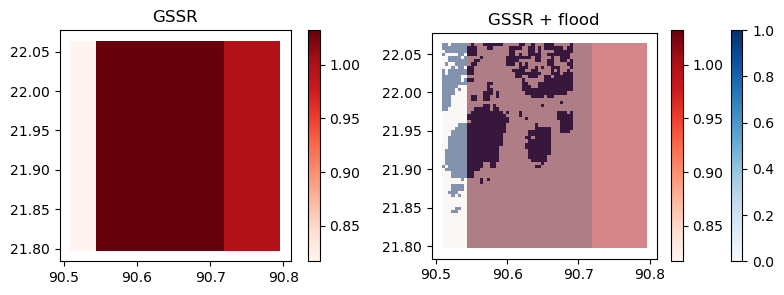

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

tile['gssr'] = closest_stations['surge']
tile.plot('floodfrac', legend=True, cmap='Blues', ax=ax[1])
tile.plot('gssr', alpha=0.5, legend=True, cmap='Reds', ax=ax[1])
tile.plot('gssr', alpha=1, legend=True, cmap='Reds', ax=ax[0])
ax[0].set_title('GSSR')
ax[1].set_title('GSSR + flood');

In [ ]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

## Heat equation bit

In [23]:
land_ind = tile[tile['dist_pw'] > 0].index
tile.loc[land_ind, 'surge'] = np.nan

<AxesSubplot: >

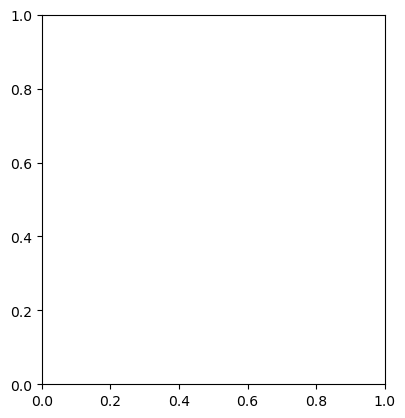

In [24]:
tile.plot('surge')

In [12]:
surge_list = tile['surge'].tolist()
surge_arr = np.reshape(surge_list, (64, 64)).T

nan_list = tile['surge'].notnull().to_list()
boundaries = np.reshape(nan_list, (64, 64)).T

sp_min = surge_arr[boundaries].min()

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
tile.plot(['surge'])

0 1
100 2
1000 3
5000 4


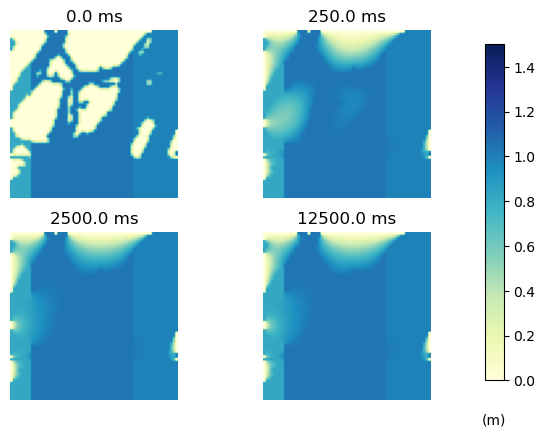

In [41]:
from matplotlib.colors import LogNorm

u0 = surge_arr
u0[np.isnan(u0)] = 0.0
u = u0.copy()

D = 1
dx = dy = 0.1
dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )
    u[boundaries] = surge_arr[boundaries]
    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 5001
# Output 4 figures at these timesteps
mfig = [0, 100, 1000, 5000]
fignum = 0
fig = plt.figure()
for m in range(nsteps):
    u0, u = do_timestep(u0, u)
    if m in mfig:
        fignum += 1
        print(m, fignum)
        ax = fig.add_subplot(220 + fignum)
        im = ax.imshow(u.copy(), cmap=plt.get_cmap('YlGnBu'), vmin=0, vmax=1.5)
        ax.set_axis_off()
        ax.set_title('{:.1f} ms'.format(m*dt*1000))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar_ax.set_xlabel('(m)', labelpad=20)
fig.colorbar(im, cax=cbar_ax)
plt.show();

# looks pr stable??

fig.savefig(join(wd, 'images', 'dev', 'surge_diffusion'), dpi=400)

## Ref

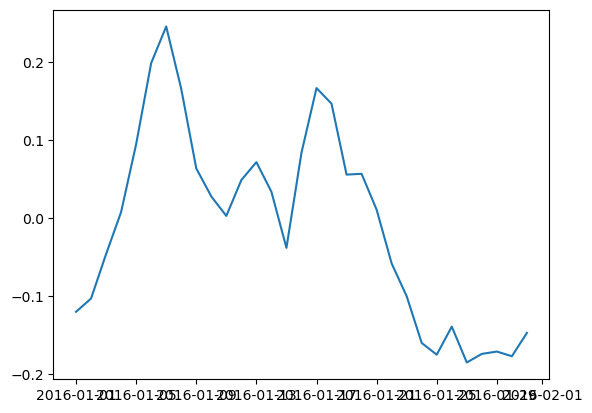

In [26]:
station_data = surge_data[surge_data['stations']==10].reset_index(drop = True)
station_data['time'] = pd.to_datetime(station_data['time'])
plt.plot(station_data['time'], station_data['surge'])

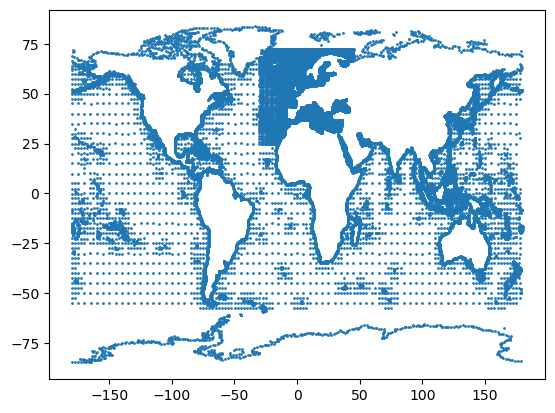

In [10]:
stations = data.stations.to_dataframe()
plt.scatter(stations['station_x_coordinate'], stations['station_y_coordinate'], s = 1)